In [ ]:
#Importing necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from setuptools.command.install import install

In [148]:
#Uploading data using False low_memory to detect and handle different types of inputs in the columns
#A copy of the raw data file is used to prevent damage of original information
#modify with your own path
path_roads= "/Users/precupada/Advanced-Simulation---Group-12/data/_roads_1.tsv"
path_bridges= "/Users/precupada/Advanced-Simulation---Group-12/data/BMMS_overview_1.xlsx"
roads= pd.read_csv(path_roads, sep='\t', low_memory=False)
bridges=pd.read_excel(path_bridges)

# Roads file: Resolving Distances between LRP points

This part of the code will focus on the _"_roads.tsv"_ file and implement a solution to eliminate noise from the data and ultimately improve the simulation output. 

In [ ]:
# Vizualizing the data
# Create a plot
plt.figure(figsize=(10, 8))

# Loop through each row in the dataframe (each road)
for index, row in roads.iterrows():
    # Extract the name of the road (first column)
    road_name = row.iloc[0]
    
    # Extract latitude and longitude values from the row
    latitudes = []
    longitudes = []
    
    # Extract latitude and longitude for each LRP, assuming columns are in a pattern
    for i in range(1, len(row), 3):  # every 3rd column is latitude and longitude
        latitudes.append(row.iloc[i+1])   # Column i+1 is latitude
        longitudes.append(row.iloc[i+2])  # Column i+2 is longitude
    
    # Plot the road (connecting the points)
    plt.plot(longitudes, latitudes, marker='o', label=f'{road_name}')

# Customize the plot
plt.title('All Roads Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)


# Show the plot
plt.show()

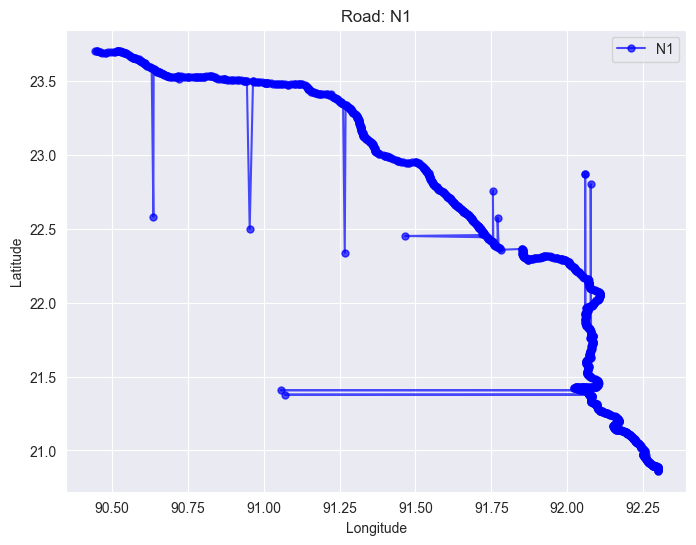

In [106]:
# Zooming into one road to take a closer look at the outliers shown in the "All roads plot" 
# Select any row from the dataframe
row = roads.iloc[0]

# Extract the name of the road (first column)
road_name = row.iloc[0]

# Extract latitude and longitude values from the row
latitudes = []
longitudes = []

# Extract latitude and longitude for each LRP
for i in range(1, len(row), 3):  # every 3rd column is latitude and longitude
    latitudes.append(row.iloc[i+1])   # Column i+1 is latitude
    longitudes.append(row.iloc[i+2])  # Column i+2 is longitude

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the road (first row)
plt.plot(longitudes, latitudes, marker='o', markersize=5, linestyle='-', color='blue', alpha=0.7, label=f'{road_name}')

# Customize the plot
plt.title(f'Road: {road_name}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

## Creating a distance function
To clean up the roads.tsv file and ensure continuity of the roads, we have to eliminate outliers amongst the LRPs for each road. To do this, we create a function that calculates the distances between the LRPs of one specific highway. We hope to eventually eliminate those LRPs that deviate too much from the average distance.

In [107]:
# Defining the function
def find_distance(row):
    latitudes = []
    longitudes = []
    distances = np.array([])
    
    # The iteration jumps in 3 columns every run, starting column 1)
    for i in range(1, len(row),3):
        latitudes.append(row.iloc[i+1])
        longitudes.append(row.iloc[i+2])
        
    # Creating an iteration to calculate the distance between two LRP using Pythagoras theorem
    # The iterator starts at 1 to be able to access the previous point using j-1
    for j in range (1, len(latitudes)):
        #converting to float to tackle longitudes and latitudes being stored as np.float64
        distance= float(np.sqrt((latitudes[j]-latitudes[j-1])**2 + (longitudes[j]-longitudes[j-1])**2)) #using pythagoras theorem to calculate distance
        distances= np.append(distances, distance)
    return distances

    

In [ ]:
# Testing the function on N1 road (and others) and seeing if distribution is somewhat normal, but it is not. 
# Feel free to change the index in line 4 to test other roads
import seaborn as sns
distances_row = find_distance(roads.iloc[659])
# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plotting histogram to see the distribution
plt.subplot(1, 2, 1)  # (rows, columns, position)
plt.hist(distances_row, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")

# Plotting box plot to identify outliers
plt.subplot(1, 2, 2)
sns.boxplot(data=distances_row, color='skyblue')
plt.title("Boxplot of Distances")
plt.ylabel("Distance")

# Show the plots
plt.tight_layout()
plt.show()


# Identifying Outliers
To identify outliers, we employ the use of percentiles to recognize the LRPs whose distances deviate too much from the majority of distances. This method is preferred over standard deviation as the distribution is not normal in the roads. The correlation between the arrays is as follows:
- The index in the latitudes and longitudes arrays correspond to index + 1, and index +2 n the row of roads [], respectively.
- The index in the distances array corresponds to the distance between index and index +1 in the latitudes and longitudes arrays.
- If an LRP is an outlier, two consecutive distances in the distances array will be outliers. Thus, two consecutive indexes will be stored in outliers_index array. This way we can check for outliers every two indexes in the outliers_index array. 
- The content of the outlier_index array corresponds to the indexes of outliers in the distances array. This means that every second checked variable in the outlier_index array corresponds to the variable+1 location in the latitudes and longitudes arrays. 
- In the end, index+1 (so outliers_array-variable +1) in the latitudes array corresponds to the LRP at position index in the roads dataframe. This means that the variable found in the outlier_index array corresponds to the index in the roads dataframe for the LRPs that are outliers. 

For example, say we take the data from the first 4 LRPs of the N1 road. The latitude and longitudes array will look like this (LRP 0,1,2,3): 
- [a,b,c,d]
- [e,f,g,h]

The distances array will look like this:
$\left[\sqrt{(b-a)^2 + (f-e)^2}, \sqrt{(c-b)^2 + (g-f)^2}, \sqrt{(d-c)^2 + (h-g)^2}\right]$

If LRP2 (c,g) is an outlier, distances at positions 1 and 2 will be outliers, and the outliers_index array will look like this: [1,2].

Since we check the outliers_index array in a step of two, we will see the selected index wil be 1. The 1 from this array, corresponds to position 1+1 in the latitudes and longitudes arrays. This means that the outlier is LRP2 (c,g) and its index in the roads dataframe is 1.


In [143]:
def find_outlier(distances):   
    #add longitude and latitude arrays as input
    # Finding the outliers
    outliers_index = []
    outliers_latitude = []
    outliers_longitude = [] 
    limit = np.percentile(distances,80)  # Adjust the percentile value as needed
    print(limit)
    
    for i in range(0, len(distances),2):
        if distances[i] > limit:
            outliers_index.append(i)

    #Store longitutes and latitudes that need to be eliminated form dataset to clear discontinuities
    for outlier_LRP in outliers_index:
        #modify to look into the longitutde and latitude arrays
        outliers_latitude.append(float(roads.iloc[0, 1+ outlier_LRP*3 +1])) # Multiply by 3 to take into account the 3 columns per LRP, add 1 in the beggining to skip the road name
        outliers_longitude.append(float(roads.iloc[0, 1+ outlier_LRP*3+ 2])) 
        
    return outliers_index, outliers_latitude, outliers_longitude
 

In [ ]:
#testing the functions on a made up dataset
test_data= pd.Series([ 7.87933335,  3.96690776,  1.20005889,  4.08106555,  9.0945608 ,
  6.24926475,  9.56687429,  2.04267342,  2.94189448,  5.54273577,
  8.66454794,  1.98329573,  2.03864279,  9.12630919,  1.09260143,
  9.5752253 ,  1.47606925,  9.35662125,  9.15188057,  9.05969162,
  7.29861896,  2.83379218,  2.81683824,  9.37257181,  9.19355721,
  8.39165449,  3.66811323,  8.41380903,  7.12615618,  9.27155382,
  3.20924606,  9.32447007,  7.91317994,  4.48005306,  2.8679023 ,
  4.72825505,  9.82844162,  8.71447804,  7.96209059,  3.96110497,
  7.29246835,  3.82898598,  6.20188668,  6.01289019,  4.28981876,
  6.85110954,  7.292056  ,  3.14969986,  9.81320412,  3.56321965,
  6.94331824,  1.24059123,  8.7137695 ,  6.12000909,  2.58015218,
  9.03457212,  9.40851736,  6.53592192,  2.88369518,  9.49166568,
  4.24520427,  2.0209155 ,  5.05715876,  8.94493934,  7.52394918,
  3.07112378,  5.05546684,  4.29700848,  5.00867744,  3.95829409,
  7.88646739,  5.63675517,  5.80670675,  5.31032564,  5.26111614,
  3.72993747,  2.12403482,  8.10681961,  5.97076286,  1.06158609,
  3.0695829 ,  7.62114897,  1.21930559,  1.75517103,  9.73531438,
  2.89574156,  8.34710458,  7.22402646,  5.2670128 ,  2.20312249,
  9.07012024,  7.62115936,  4.06148188,  1.27004129,  5.10740386,
  7.42073512,  6.87517948,  9.02588805,  9.06501345,  8.39061373,
  50.        , 55.        , 60.        ])
distances= find_distance(test_data)
print(distances)
outliers_index, outliers_latitude, outliers_longitude = find_outlier(distances)
print(outliers_longitude)

# Smoothening the data
### Interpolation

To correct the data where outliers are found, we use interpolation to fill in the missing values. This is done by taking the average of the two closest points to the outlier. We use this method od estimation to tackle the accuracy issue of the roads dataset and to ensure continuity and linearity of the roads.

In [109]:
print(roads.iloc[0])

road                    N1
lrp1                  LRPS
lat1             23.706028
lon1             90.443333
lrp2                 LRPSa
                   ...    
Unnamed: 4040    20.862972
Unnamed: 4041    92.298083
Unnamed: 4042         LRPE
Unnamed: 4043    20.862917
Unnamed: 4044    92.298083
Name: 0, Length: 4045, dtype: object


In [127]:
def interpolate_outliers(outliers_index):
    # Interpolating the outliers
    road_newroads = roads.copy()
    for call in outliers_index:
        # Calculate the average of the two closest points
        if call>0 and call<len(road_newroads.columns)/3-1:
            avg_lat = (float(roads.iloc[0, 1+ (call-1) *3 +1]) + float(roads.iloc[0, 1+ (call+1)*3 +1])) / 2
            avg_long = (float(roads.iloc[0, 1+ (call-1) *3 +2]) + float(roads.iloc[0, 1+ (call+1)*3 +2])) / 2
        
            # Replace the outliers with the average value
            road_newroads.iloc[0, 1+ call*3 +1] = avg_lat
            road_newroads.iloc[0, 1+ call*3 +2] = avg_long
        
    return road_newroads

In [144]:
#Testing on individual road
distance_row= find_distance(roads.iloc[0])
print(len(roads.iloc[0]))
print(len(distance_row))
outliers_index, outliers_latitude, outliers_longitude = find_outlier(distance_row)
interpolated_base= interpolate_outliers(outliers_index)



4045
1347
0.005679449092405788


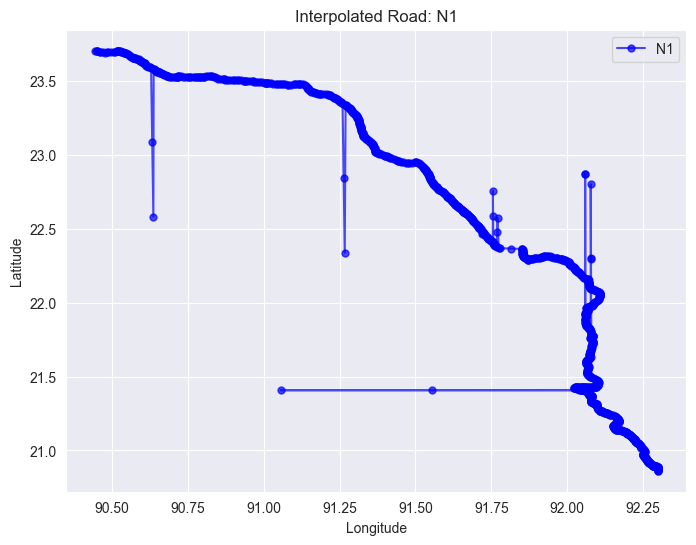

In [145]:
# Visualizing interpolated road
#It's kind of working, but maybe use previous values to interpolate (forward fill)
row = interpolated_base.iloc[0]

# Extract the name of the road (first column)
road_name = row.iloc[0]

# Extract latitude and longitude values from the row
latitudes = []
longitudes = []

# Extract latitude and longitude for each LRP
for i in range(1, len(row), 3):  # every 3rd column is latitude and longitude
    latitudes.append(row.iloc[i+1])   # Column i+1 is latitude
    longitudes.append(row.iloc[i+2])  # Column i+2 is longitude

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the road (first row)
plt.plot(longitudes, latitudes, marker='o', markersize=5, linestyle='-', color='blue', alpha=0.7, label=f'{road_name}')

# Customize the plot
plt.title(f'Interpolated Road: {road_name}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()